In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import warnings

import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb  # Load this xgboost
from xgboost import XGBClassifier


In [2]:
# Download necessary resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 100)


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Load the Data

In [5]:
products_review_data = pd.read_csv('/content/drive/MyDrive/Capstone/sample30.csv')
data_attr_desc = pd.read_csv('/content/drive/MyDrive/Capstone/Data_Attribute_Description.csv',encoding='ISO-8859-1')

# 1. Exploratory Data Analysis

#### **Understanding the Data**

In [6]:
products_review_data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Ho...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, an...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my ...,Irritation,NaN,NaN,walker557,Negative


In [7]:
# Understanding the data definitions

data_attr_desc

,Attribute,Attribute Description
0,id,Uniques identity number to identify each unique review given by the user to a particular product...
1,brand,Name of the brand of the product to which user has given review and rating
2,categories,"Category of the product like household essentials, books, personal care products, medicines, cos..."
3,manufacturer,Name of the manufacturer of the product
4,name,Name of the product to which user has added review or rating
5,reviews_date,Date on which the review has been added by the user
6,reviews_didPurchase,Whether a particular user has purchased the product or not
7,reviews_doRecommend,Whether a particular user has recommended the product or not
8,reviews_rating,Rating given by the user to a particular product
9,reviews_text,Review given by the user to a particular product


In [8]:
print("Shape of data:", products_review_data.shape)

Shape of data: (30000, 15)


In [9]:
# Display the structure of the DataFrame

products_review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [10]:
# Inspect the row where user sentiment is null

user_sentiment_is_null = products_review_data[products_review_data.user_sentiment.isnull()]
user_sentiment_is_null


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Mo...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2014-11-07T00:00:00.000Z,NaN,True,5,my kids absolutely loved this film so much that we watched it twice. Having a digital copy means...,a super hit with my children. they loved it!!??,NaN,mamad,7.87E+11,NaN


In [11]:
print(user_sentiment_is_null['reviews_text'])

28354    my kids absolutely loved this film so much that we watched it twice. Having a digital copy means...
Name: reviews_text, dtype: object


In [12]:
# Number of Unique users

unique_users = products_review_data['reviews_username'].nunique()
print("Total Not null Users:",products_review_data['reviews_username'].notnull().sum())
print(f"Number of unique users: {unique_users}")

Total Not null Users: 29937
Number of unique users: 24914


In [13]:
# Analysis in Reviews Rating

products_review_data['reviews_rating'].value_counts()

,count
reviews_rating,
5,20831
4,6020
1,1384
3,1345
2,420


In [14]:
# Analysis by name to which the user has provided rating/review

products_review_data['name'].value_counts().head(10)

,count
name,
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8545
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,3325
Clorox Disinfecting Bathroom Cleaner,2039
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,1186
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1143
"Burt's Bees Lip Shimmer, Raisin",873
The Resident Evil Collection 5 Discs (blu-Ray),845
Mike Dave Need Wedding Dates (dvd + Digital),757
Nexxus Exxtra Gel Style Creation Sculptor,693


In [15]:
# Analysis by name to which the user has provided rating/review

print(products_review_data['manufacturer'].value_counts().head(10))

manufacturer
Clorox                    8546
Test                      3325
AmazonUs/CLOO7            2039
L'oreal Paris             1232
Walt Disney               1143
Burt's Bees                873
SONY CORP                  845
Twentieth Century Fox      757
P&G                        730
Nexxus Beauty Products     693
Name: count, dtype: int64


In [16]:
# User Sentiment counts
products_review_data['user_sentiment'].value_counts()

,count
user_sentiment,
Positive,26632
Negative,3367


In [17]:
# Check for Null values in each column
print("\nNull values in each column:")
print(products_review_data.isnull().sum())


Null values in each column:
id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64


In [18]:
null_values_percent = (products_review_data.isnull().sum() / len(products_review_data)) * 100
print(null_values_percent)

id                       0.000000
brand                    0.000000
categories               0.000000
manufacturer             0.470000
name                     0.000000
reviews_date             0.153333
reviews_didPurchase     46.893333
reviews_doRecommend      8.566667
reviews_rating           0.000000
reviews_text             0.000000
reviews_title            0.633333
reviews_userCity        93.570000
reviews_userProvince    99.433333
reviews_username         0.210000
user_sentiment           0.003333
dtype: float64


In [19]:
# check for duplicates

duplicate_rows = products_review_data.duplicated().sum()
duplicate_rows

np.int64(0)

In [20]:
duplicates_all = products_review_data[products_review_data.duplicated(subset=['reviews_username', 'name', 'reviews_date', 'reviews_text'],keep=False)]
print(f"Exact duplicates: {duplicates_all.shape[0]}")


Exact duplicates: 113


In [21]:
duplicates_all.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
67,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face Moisturizers,Facial Moisturizers,Moisturizers,Cre...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,NaN,True,3,"Today is my first time using this product. Felt great going on immediately, felt moisturized wit...",Why No Fragrance-Free Formula,Brooklyn,NaN,mylifeinheels,Positive
90,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face Moisturizers,Facial Moisturizers,Moisturizers,Cre...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,NaN,True,3,"Today is my first time using this product. Felt great going on immediately, felt moisturized wit...",Why No Fragrance-free Formula,Brooklyn,NaN,mylifeinheels,Positive
1281,AV1Ys0kTvKc47QAVgx1C,Meguiars,"Home,Home Improvement,Automotive,Car Cleaning,Auto & Tires,Auto Detailing & Car Care,Exterior Ca...",Parts,Meguiar's Deep Crystal Car Wash 64-Oz.,2017-02-16T21:47:38.000Z,NaN,True,5,Meguiar's Deep Crystal Car Wash 64-oz. is top of the line car wash with excellent properties wit...,"Meguiar's Deep Crystal Car Wash: ""the Benchmark Of Quality""",NaN,NaN,synoptic 12,Positive
1282,AV1Ys0kTvKc47QAVgx1C,Meguiars,"Home,Home Improvement,Automotive,Car Cleaning,Auto & Tires,Auto Detailing & Car Care,Exterior Ca...",Parts,Meguiar's Deep Crystal Car Wash 64-Oz.,2017-02-16T21:47:38.000Z,NaN,True,5,Meguiar's Deep Crystal Car Wash 64-oz. is top of the line car wash with excellent properties wit...,"Meguiar's Deep Crystal Car Wash: ""The Benchmark Of Quality""",NaN,NaN,synoptic 12,Positive
3684,AVpe7GIELJeJML43yZfu,Eagle Brand,"Food,Packaged Foods,Baking,Canned or Dried Milk,Food & Beverage,Baking & Cooking Essentials,Baki...","Eagle Family Foods, Inc.",Eagle Fat Free Sweetened Condensed Milk,2016-12-31T17:36:36.000Z,NaN,True,5,"Love the fat free when it delivers rich, creamy taste. I've used this product before--also the E...",Love Eagle Brand--Fat Free!!!,NaN,NaN,p9,Positive


#### **Visualizations**

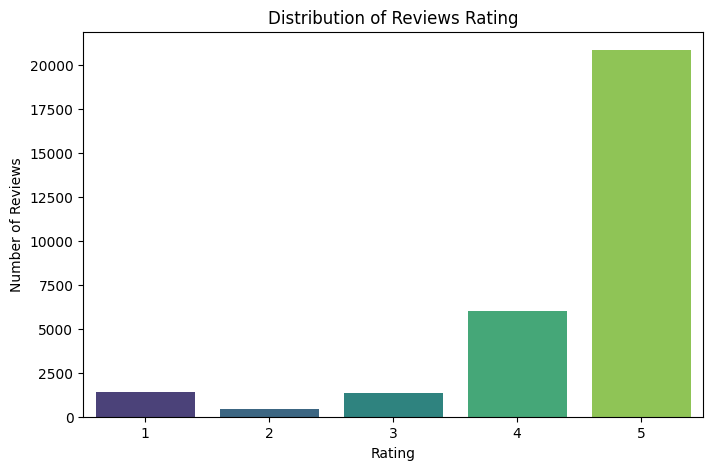

In [22]:
plt.figure(figsize=(8, 5))
sns.countplot(x='reviews_rating', data=products_review_data, palette='viridis')
plt.title('Distribution of Reviews Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

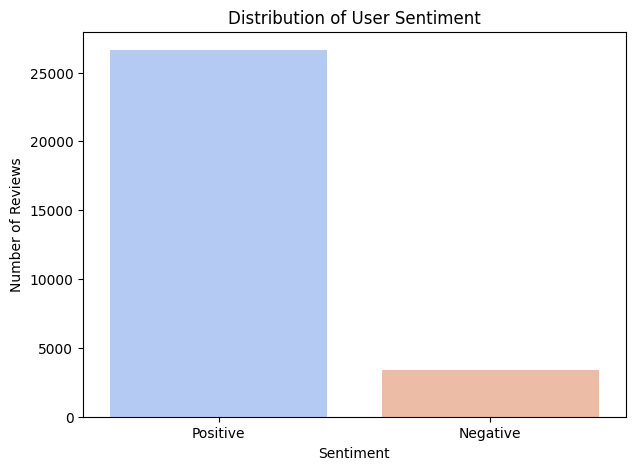

In [23]:
# Investigate the distribution of user_sentiment
plt.figure(figsize=(7, 5))
sns.countplot(x='user_sentiment', data=products_review_data, palette='coolwarm')
plt.title('Distribution of User Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


Top 10 most active reviewers:
reviews_username
byamazon customer    41
mike                 41
chris                32
lisa                 16
sandy                15
tony                 15
rick                 15
dave                 14
john                 14
jojo                 13
Name: count, dtype: int64


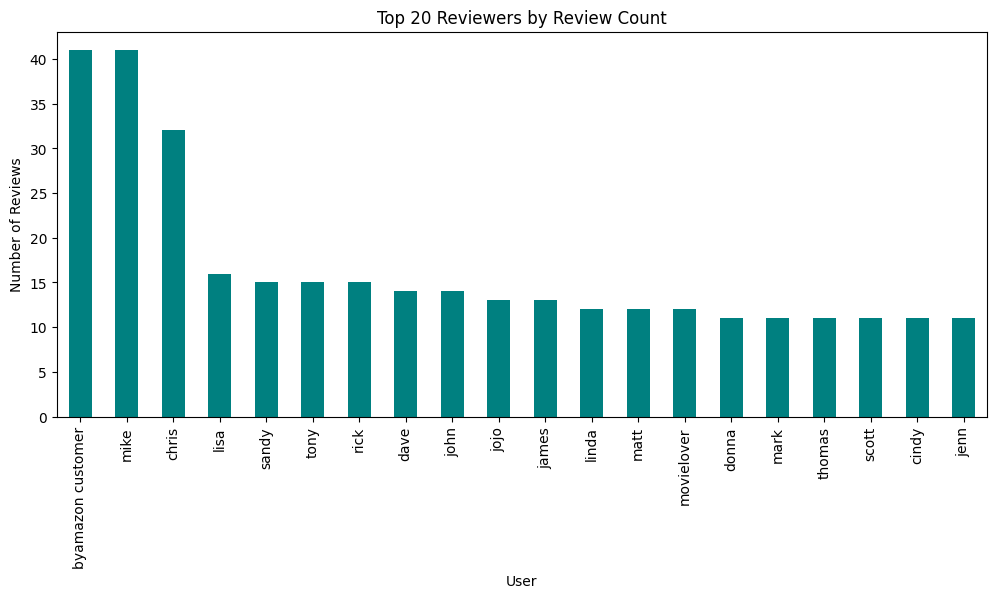

In [24]:
# Reviews per user
reviews_per_user = products_review_data['reviews_username'].value_counts()
print("\nTop 10 most active reviewers:")
print(reviews_per_user.head(10))

# Plot: Number of reviews per user (top 20)
plt.figure(figsize=(12,5))
reviews_per_user.head(20).plot(kind='bar', color='teal')
plt.title("Top 20 Reviewers by Review Count")
plt.xlabel("User")
plt.ylabel("Number of Reviews")
plt.show()


Top 10 most reviewd products :
id
AVpf3VOfilAPnD_xjpun    8545
AVpfPaoqLJeJML435Xk9    3325
AVpfJP1C1cnluZ0-e3Xy    2039
AVpfW8y_LJeJML437ySW    1186
AVpfRTh1ilAPnD_xYic2    1143
AVpf63aJLJeJML43F__Q     873
AVpf0eb2LJeJML43EVSt     845
AVpe41TqilAPnD_xQH3d     757
AVpfm8yiLJeJML43AYyu     693
AVpf2tw1ilAPnD_xjflC     672
Name: count, dtype: int64


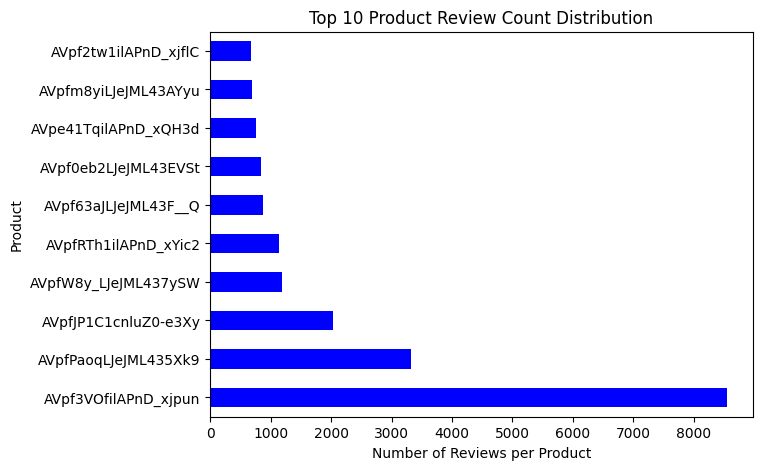

In [25]:
# Product Review count distribution
reviews_per_product = products_review_data['id'].value_counts()
print("\nTop 10 most reviewd products :")
print(reviews_per_product.head(10))

# Plot: Number of Reviews per Product top 10
plt.figure(figsize=(7,5))
reviews_per_product.head(10).plot(kind='barh', color='blue',)
plt.title("Top 10 Product Review Count Distribution")
plt.xlabel("Number of Reviews per Product")
plt.ylabel("Product")
plt.show()

In [26]:
## Inspect user_sentiment vs reviews rating

products_review_data[(products_review_data["user_sentiment"]=='Positive') & (products_review_data["reviews_rating"]<4)][["reviews_title","reviews_text", "reviews_rating","user_sentiment"]]

,reviews_title,reviews_text,reviews_rating,user_sentiment
9,Don't buy,Got as a surprise for my husband there is nothing special about it just a lube save the money an...,1,Positive
11,Waste of Money,Purchased this thinking it would have some sort of warming effect but it's the same as the origi...,1,Positive
14,Disappointed,First time purchase of this type of product. Maybe I expected too much. Did not think there was ...,1,Positive
18,Pretty nice,"I bought this because it had better reviews than the his and hers jelly, but I feel like it didn...",3,Positive
54,New formula is terrible,I used (and loved) this product for several years until they changed it. It used to moisturize m...,1,Positive
...,...,...,...,...
29050,Didn't Do Much For Dryness,"I received this product from Influenster. I absolutely love the whole system together, it made m...",3,Positive
29051,Not the best,I used this product for a month straight before reviewing it and I'm not really all that impress...,3,Positive
29053,clay conditioning,Got this item as a compliment from influenster but it really made my hair smooth and shining aft...,3,Positive
29054,Eh,I am not in love with the conditioner. The clay mask and shampoo are GREAT but I didn't feel lik...,3,Positive


In [27]:
products_review_data[(products_review_data["user_sentiment"]=="Negative") & (products_review_data["reviews_rating"]>=4)][["reviews_title","reviews_text", "reviews_rating","user_sentiment"]]

,reviews_title,reviews_text,reviews_rating,user_sentiment
92,hydrating but not too heavy,It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected a...,4,Negative
96,This product has made a real difference on my skin,In only a week I can see the difference in my skin on my face. This review was collected as part...,4,Negative
100,Noticed a difference in just two weeks!,This product has made my skin smoother and supple after only two weeks. It absorbs well and leav...,4,Negative
106,Very rich cream,"I like to use this cream on my neck and collarbone to help keep my skin well moisturized, but it...",4,Negative
117,Not greasy,I finally found a moisturizing product that will absorb completely and not leave my skin feeling...,4,Negative
...,...,...,...,...
29818,Great Product,I received a complimentary sample of this product and it worked so well for my hair! I have very...,5,Negative
29855,Great,This has prolonged the color in my hair! Not only is my hair healthier but I think I'll have to ...,5,Negative
29858,Makes my hair soft and shiny without excess oil!,This conditioner makes my hair very soft without weighing it down! I was afraid it'd make my roo...,5,Negative
29862,Great Conditioner,This conditioner has become a staple in my hair regimen This review was collected as part of a p...,5,Negative


In [28]:
pd.crosstab(products_review_data["user_sentiment"], products_review_data["reviews_rating"])

reviews_rating,1,2,3,4,5
user_sentiment,,,,,
Negative,597,140,220,550,1860
Positive,787,280,1125,5470,18970


### **Summarizing what we understood by inspecting the data**
```
1. Impute a row where the user sentiment is null basis on rating
2. Drop columns where null percent is high (>90%)
3. Incorrect correlation between rating and user sentiment. Correct this by creating a new label or correcting the usersentiment basis on review text and rating.
4. Positive sentiment class dominates in the data. We can handle this using class imbalance techniques for model training.
```



# 2. Data Cleaning

In [29]:
## Step 1:Droping Columns where null percentage is high

# reviews_userCity        93.570000
# reviews_userProvince    99.433333

products_review_data.drop(['reviews_userCity','reviews_userProvince'],axis=1,inplace=True)
products_review_data.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [30]:
## Step 2:Remove Duplicates

# Defining duplicates based on username, product name, date, and text

print(f"Shape before removing duplicates: {products_review_data.shape}")
products_review_data = products_review_data.drop_duplicates(subset=['reviews_username', 'name', 'reviews_date', 'reviews_text'])
print(f"Shape after removing duplicates: {products_review_data.shape}")

Shape before removing duplicates: (30000, 13)
Shape after removing duplicates: (29943, 13)


In [31]:
## Step 3:For user_sentiment: impute based on rating (derived sentiment)

# rating >= 3 = Positive and rating < 3 Negative

def derive_user_sentiment(x):
  if x >= 3:
    return 'Positive'
  else:
    return 'Negative'

In [32]:
products_review_data['user_sentiment'] = products_review_data['reviews_rating'].apply(derive_user_sentiment)

In [33]:
pd.crosstab(products_review_data["user_sentiment"], products_review_data["reviews_rating"])

reviews_rating,1,2,3,4,5
user_sentiment,,,,,
Negative,1383,420,0,0,0
Positive,0,0,1343,6013,20784


In [34]:
# Inspecting the dataframe before we proceed for Text Preprocessing

products_review_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29943 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   29943 non-null  object
 1   brand                29943 non-null  object
 2   categories           29943 non-null  object
 3   manufacturer         29802 non-null  object
 4   name                 29943 non-null  object
 5   reviews_date         29897 non-null  object
 6   reviews_didPurchase  15894 non-null  object
 7   reviews_doRecommend  27375 non-null  object
 8   reviews_rating       29943 non-null  int64 
 9   reviews_text         29943 non-null  object
 10  reviews_title        29753 non-null  object
 11  reviews_username     29880 non-null  object
 12  user_sentiment       29943 non-null  object
dtypes: int64(1), object(12)
memory usage: 3.2+ MB


# 3. Text Preprocessing

In [35]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [36]:
def preprocess_text(text):
    text = str(text).lower()  # 1. Lowercasing
    text = ''.join([i for i in text if not i.isdigit()]) # 2. Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # 3. Remove punctuation
    text = re.sub(r'\s+', ' ', text) # 4. Remove extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text) # 5. Remove special characters/emojis
    tokens = nltk.word_tokenize(text) # 6. Tokenization
    tokens = [word for word in tokens if word not in stop_words] # 7. Stopword removal
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # 8. Lemmatization

    return ' '.join(tokens)


In [37]:
# Combine title and text for richer context
products_review_data['full_review'] = (products_review_data['reviews_title'].fillna('') + ' ' + products_review_data['reviews_text'].fillna('')).str.strip()

from tqdm import tqdm
tqdm.pandas()
# Apply preprocessing
products_review_data['cleaned_review'] = products_review_data['full_review'].progress_apply(preprocess_text)


100%|██████████| 29943/29943 [00:10<00:00, 2928.37it/s]


In [38]:
# Preview
products_review_data[['reviews_title', 'reviews_text', 'cleaned_review']].tail(10)

,reviews_title,reviews_text,cleaned_review
29990,Smells Amazing!,"This whole set of these (mask, shampoo and conditioner) works lovely. My roots get oily quickly ...",smell amazing whole set mask shampoo conditioner work lovely root get oily quickly didnt smell m...
29991,Great clay products!,"Took the 48 hour hair challenge using the shampoo, conditioner and clay mask. this was the 1st t...",great clay product took hour hair challenge using shampoo conditioner clay mask st time ive hear...
29992,Smells Amazing,I absolutely love the smell of this product! I have fine hair that is oily at the roots but the ...,smell amazing absolutely love smell product fine hair oily root end dry left hair feeling soft e...
29993,Ends feel so soft!,I seriously was so surprised after my shower how soft and healthy my shaft and ends felt and loo...,end feel soft seriously surprised shower soft healthy shaft end felt looked mention super soft r...
29994,"By far, my new favorite conditioner",I got to try this conditioner for free and boy am I glad I did! It's amazing. It leaves your hai...,far new favorite conditioner got try conditioner free boy glad amazing leaf hair soft manageable...
29995,Softness!!,"I got this conditioner with Influenster to try it and im loving it so far, i have oily hair so i...",softness got conditioner influenster try im loving far oily hair use end hair feel amazing soft ...
29996,I love it,"I love it , I received this for review purposes from influenster and it leaves my hair feeling f...",love love received review purpose influenster leaf hair feeling fresh smelling great
29997,Hair is so smooth after use,First of all I love the smell of this product. After you wash your hair it is so smooth and easy...,hair smooth use first love smell product wash hair smooth easy brush receive product influenster...
29998,Perfect for my oily hair!,I received this through Influenster and will never go back to anything else! I normally don't us...,perfect oily hair received influenster never go back anything else normally dont use conditioner...
29999,Conditioned into healthy,I received this product complimentary from influenster and it has really saved my hair. This pro...,conditioned healthy received product complimentary influenster really saved hair product really ...


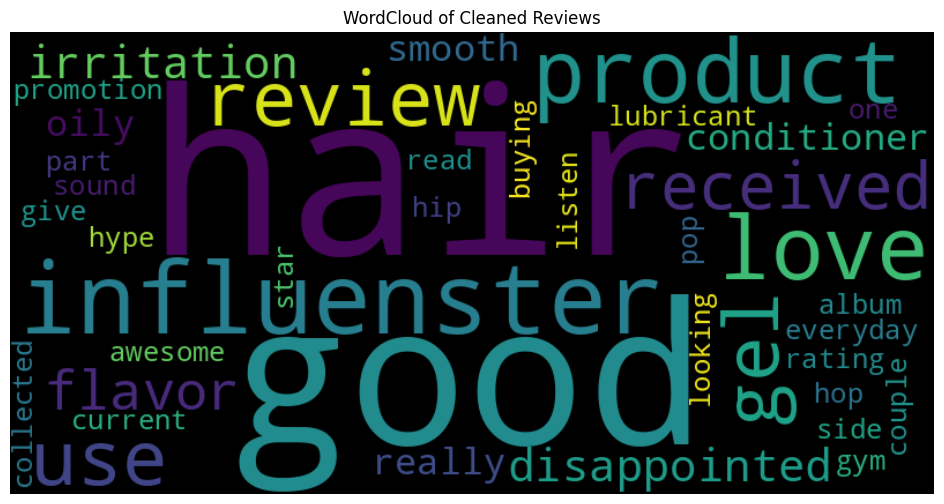

In [39]:
# Generate Word Cloud

wordcloud = WordCloud(width=800, height=400, max_words=40, background_color="black").generate(str(products_review_data['cleaned_review']))

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("WordCloud of Cleaned Reviews")
plt.show()

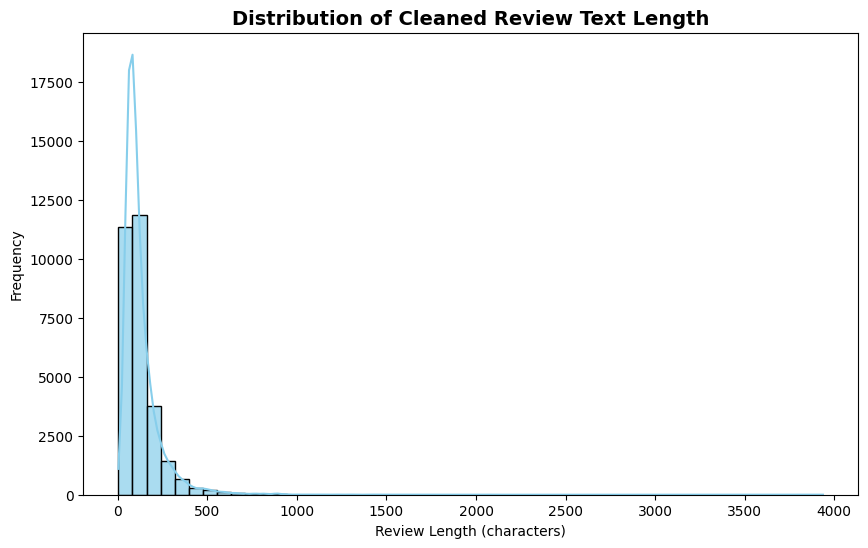

In [40]:
# Plotting the length of reviews_text

plt.figure(figsize=(10, 6))

review_length = products_review_data['cleaned_review'].astype(str).str.len()
sns.histplot(review_length, bins=50, kde=True, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Cleaned Review Text Length', fontsize=14, fontweight='bold')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.show()

In [41]:
print("\n--- 7. Analysis of 'reviews_text' length ---")
print(review_length.describe())


--- 7. Analysis of 'reviews_text' length ---
count    29943.000000
mean       128.660689
std        118.130550
min          3.000000
25%         66.000000
50%         97.000000
75%        151.000000
max       3937.000000
Name: cleaned_review, dtype: float64


# 4. Feature Extraction

In [42]:
#Encode the negative and positive to 0 and 1 respectively

products_review_data['user_sentiment'] = products_review_data['user_sentiment'].map({'Negative':0,'Positive':1})
products_review_data['user_sentiment'].value_counts()

,count
user_sentiment,
1,28140
0,1803


In [43]:
# using TF-IDF vectorizer method to dervie the features from the textual data

# TF-IDF Vectorization is a robust choice as it
# considers both the frequency of words in a document and their importance across the entire corpus.

In [44]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=1000,  max_df=0.95, min_df=3, ngram_range=(1,2))  # Unigrams + bigrams, top 5000 features

# Fit on cleaned text and transform
X = tfidf.fit_transform(products_review_data['cleaned_review'])

# Features shape
print("TF-IDF Shape:", X.shape)

TF-IDF Shape: (29943, 1000)


In [45]:
# Convert to DataFrame for inspection (top features)

feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(X.toarray(), columns=feature_names)
tfidf_df.head()

,able,absolutely,absolutely love,acting,action,action movie,action packed,actor,actually,add,added,addition,adult,age,ago,album,almost,along,alot,already,also,also use,although,always,amazing,amazing product,amount,another,anymore,anyone,anything,anything else,anywhere,application,apply,area,around,around house,available,away,awesome,awesome love,awesome movie,awesome product,awful,baby,back,back cocoa,back old,bad,bag,balm,bath,bathroom,bathroom kitchen,bathroom review,beat,beautiful,bee,behind,believe,best,best buy,best godzilla,best product,better,big,binder,bit,black,bleach,blend,blu,blu ray,blue,bluray,body,bottle,bought,box,boy,brand,bring,bring back,brown,brush,burt,burt bee,butter,buy,buying,came,canister,cant,cant live,cant wait,car,care,carpet,carry,...,ups,us,use,use clean,use clorox,use daily,use every,use everyday,use everything,use great,use kitchen,use love,use product,use review,use time,use wipe,used,used product,useful,using,using clorox,using product,using wipe,usually,vacuum,value,version,video,volume,wait,walmart,want,wanted,wash,washing,wasnt,watch,watched,watching,water,way,way clean,wear,wedding,week,weight,well,well review,went,white,whole,whole family,wife,windex,window,winter,wipe,wipe best,wipe clean,wipe clorox,wipe convenient,wipe easy,wipe everything,wipe great,wipe love,wipe make,wipe review,wipe use,wipe wipe,wiping,wish,within,without,wonder,wonderful,wonderful product,wont,wood,work,work great,work well,worked,working,worry,worth,would,would definitely,would like,would recommend,wouldnt,wrong,year,year ago,year old,yes,yet,youll,young,younger,youre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.215519,0.353628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### **COMMOM UTILITIES**

In [46]:
# Function to calculate metrics and return as a DataFrame
def get_metrics_df(y_true, y_pred, y_pred_proba, classifier):
    metrics = {
        'Accuracy': round(accuracy_score(y_true, y_pred),2),
        'Precision': round(precision_score(y_true, y_pred),2),
        'Recall': round(recall_score(y_true, y_pred),2),
        'F1 Score': round(f1_score(y_true, y_pred),2),
        'AUC': round(roc_auc_score(y_true, y_pred_proba),2),
    }
    metrics_df = pd.DataFrame(metrics, index=[classifier]).T
    return metrics_df

In [47]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, classifier, label_prefix=""):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(4, 3))  # Smaller size
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{classifier} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)

    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('ROC Curve', fontsize=10,fontweight='bold')
    plt.legend(loc='lower right', fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [48]:
# Function to plot heatmap of confusion matrix
def plot_confusion_matrix(y_true, y_pred, classifier):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    ax.set_title(f'Confusion Matrix for {classifier}', fontsize=10,fontweight='bold')
    ax.set_xlabel('Predicted Values', fontsize=10)
    ax.set_ylabel('True Values', fontsize=10)
    ax.set_xticklabels([0,1])
    ax.set_yticklabels([0,1])
    plt.tight_layout()
    plt.show()

In [49]:
all_metrics_df = pd.DataFrame()
# Main function to evaluate model
def evaluate_model(model, X_test, y_test,classifier):
    global all_metrics_df  # Use the global variable
    #plt.figure(figsize=(7, 5))
    all_confusion_matrices = {}
    X = X_test
    y_true = y_test

    # Predictions
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]

    # Calculate and collect metrics as a transposed DataFrame
    metrics_df = get_metrics_df(y_true, y_pred, y_pred_proba, classifier)
    all_metrics_df = pd.concat([all_metrics_df, metrics_df.T], axis=0)

    # Print Classification report
    print(classification_report(y_true, y_pred, digits=3))
    print("\n\n")

    # Plot confusion matrix and ROC Curve
    plot_confusion_and_roc(y_true, y_pred,y_pred_proba,classifier)
    print("\n\n")

In [50]:
sns.set_style("darkgrid")

def plot_confusion_and_roc(y_true, y_pred, y_pred_proba, classifier):
    # Create figure with 2 subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=True,
                ax=axes[0], annot_kws={"size": 10})
    axes[0].set_title('Confusion Matrix', fontsize=10, fontweight='bold')
    axes[0].set_xlabel('Predicted Values', fontsize=10)
    axes[0].set_ylabel('True Values', fontsize=10)

    # ---- ROC Curve ----
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'{classifier} (AUC = {auc_score:.2f})')
    axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[1].set_title('ROC Curve', fontsize=10, fontweight='bold')
    axes[1].set_xlabel('False Positive Rate', fontsize=10)
    axes[1].set_ylabel('True Positive Rate', fontsize=10)
    axes[1].legend(loc='lower right', fontsize=9)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


# 5. Training the text classification model

In [51]:
X = X  # TF-IDF matrix from Step 4
y = products_review_data['user_sentiment']

In [52]:
# Split into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (23954, 1000) Test shape: (5989, 1000)


*   Apply SMOTE before splitting, synthetic samples created from the training data can “leak” into the test set
*   The test set should represent the real-world data distribution, which is usually imbalanced.
*   The stratify parameter ensures that the class distribution in the train and test sets is the same as in the original dataset.
In simple words: If  dataset is imbalanced (e.g., 80% Positive, 20% Negative), stratify=y will keep the same 80:20 ratio in both train and test sets.



In [53]:
# **Handling Class Imbalance** - Using SMOTE for oversampling

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: user_sentiment
1    22512
0     1442
Name: count, dtype: int64
After SMOTE: user_sentiment
1    22512
0    22512
Name: count, dtype: int64


#### **Logistic Regression**

In [54]:
# Train logistic regression model

log_reg = LogisticRegression(class_weight="balanced",max_iter=100,solver='liblinear',)
log_reg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(class_weight='balanced', solver='liblinear')

              precision    recall  f1-score   support

           0      0.424     0.881     0.572       361
           1      0.992     0.923     0.956      5628

    accuracy                          0.921      5989
   macro avg      0.708     0.902     0.764      5989
weighted avg      0.958     0.921     0.933      5989






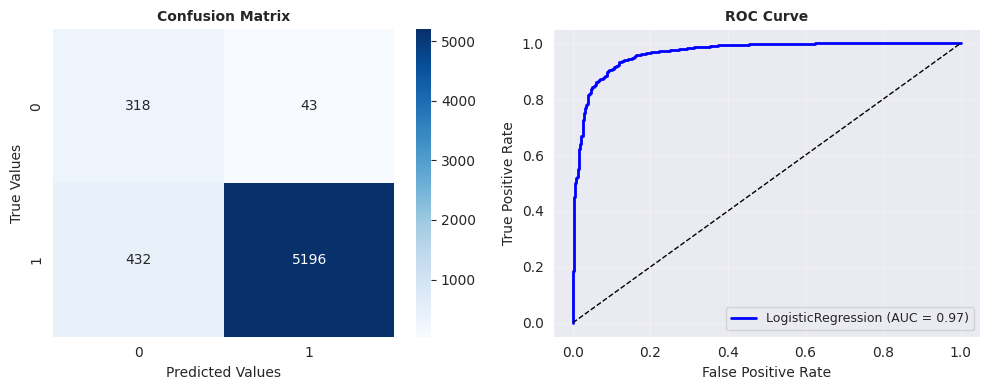

In [55]:
# Run evaluation for logistic regression model and plot confusion metrics and ROC curve
lr_evaluation_metrics = evaluate_model(log_reg,X_test, y_test,'LogisticRegression')

#### **Naive Bayes**

In [56]:
mnb = MultinomialNB()
mnb.fit(X_train_resampled,y_train_resampled)

MultinomialNB()

              precision    recall  f1-score   support

           0      0.346     0.861     0.494       361
           1      0.990     0.896     0.941      5628

    accuracy                          0.894      5989
   macro avg      0.668     0.879     0.717      5989
weighted avg      0.951     0.894     0.914      5989






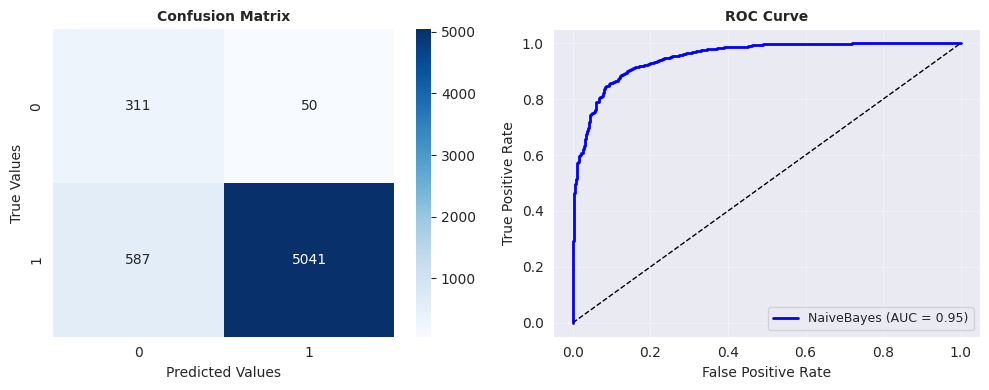

In [57]:
# Run evaluation for Naive Bayes model
mnb_evaluation_metrics = evaluate_model(mnb,X_test, y_test,'NaiveBayes')

#### **Random Forest**

In [58]:
rf = RandomForestClassifier(random_state=42,oob_score=True)

In [59]:
params_rf = {
    'max_depth': [3,5,7,9,10],
    'min_samples_leaf' : [10,20,30,40,50],
    'n_estimators': [50, 100, 200],
    'class_weight': ['balanced', None]  # Add this
}


rf_grid_search = GridSearchCV(estimator = rf, param_grid= params_rf, cv=5,
                          n_jobs= -1,verbose=1,scoring='f1_macro')

In [60]:
%%time
rf_grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
CPU times: user 4.31 s, sys: 381 ms, total: 4.69 s
Wall time: 2min 11s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [3, 5, 7, 9, 10],
                         'min_samples_leaf': [10, 20, 30, 40, 50],
                         'n_estimators': [50, 100, 200]},
             scoring='f1_macro', verbose=1)

In [61]:
rf_best = rf_grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, min_samples_leaf=10, oob_score=True,
                       random_state=42)

              precision    recall  f1-score   support

           0      0.969     0.346     0.510       361
           1      0.960     0.999     0.979      5628

    accuracy                          0.960      5989
   macro avg      0.964     0.673     0.745      5989
weighted avg      0.960     0.960     0.951      5989






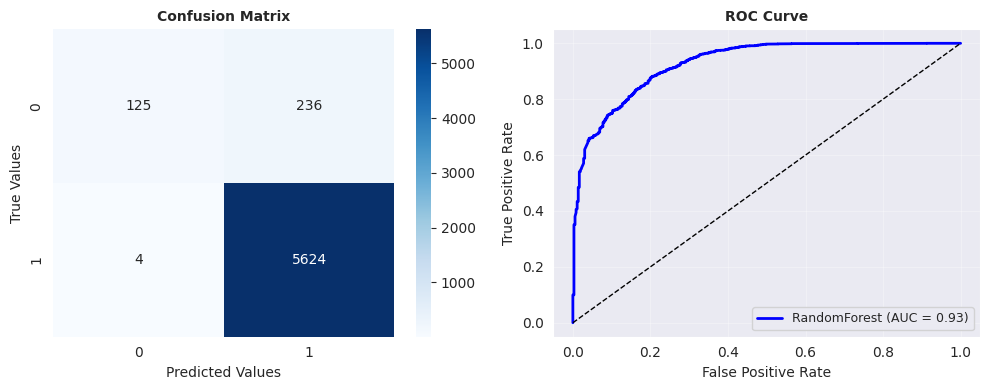

In [62]:
rf_evaluation_metrics = evaluate_model(rf_best,X_test, y_test,'RandomForest')

#### **XGBoost**

In [63]:
xgb_model = XGBClassifier(random_state=100 , n_jobs=-1 )

In [64]:
from scipy.stats import uniform, randint
param_dist = {
    'n_estimators': randint(50, 100),  # Random integers between 50 and 200
    'learning_rate': uniform(0.1, 0.5),  # Uniform distribution between 0.01 and 0.2
    'max_depth': randint(3, 15),  # Random integers between 3 and 15
    'subsample': uniform(0.6, 0.4),  # Uniform distribution between 0.6 and 1
    'colsample_bytree': uniform(0.6, 0.4),  # Uniform distribution between 0.6 and 1
    'gamma': uniform(0, 0.5)  # Uniform distribution between 0 and 0.5
}

In [65]:
randomized_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of random combinations to try
    scoring='f1_macro',  # Performance metric
    n_jobs=-1,  # Use all available cores for parallel processing
    cv=3,  # 3-fold cross-validation
    verbose=2,  # Print progress
    random_state=42
)


In [66]:
%%time
randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
CPU times: user 1min 1s, sys: 609 ms, total: 1min 2s
Wall time: 3min 16s


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d699bee9a10>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d699bd64810>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d699b846c50>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d699be5ccd0>},
                   random_state=42, scoring='f1_macro', verbose=2)

In [67]:
print("Best Parameters Found: ", randomized_search.best_params_)
print("Best F1 Macro Score: ", randomized_search.best_score_)

xgb_best_model = randomized_search.best_estimator_

Best Parameters Found:  {'colsample_bytree': np.float64(0.987032220608099), 'gamma': np.float64(0.27398594162404366), 'learning_rate': np.float64(0.3117354711540593), 'max_depth': 10, 'n_estimators': 84, 'subsample': np.float64(0.9962020568002693)}
Best F1 Macro Score:  0.851363455124893


              precision    recall  f1-score   support

           0      0.878     0.598     0.712       361
           1      0.975     0.995     0.985      5628

    accuracy                          0.971      5989
   macro avg      0.926     0.797     0.848      5989
weighted avg      0.969     0.971     0.968      5989






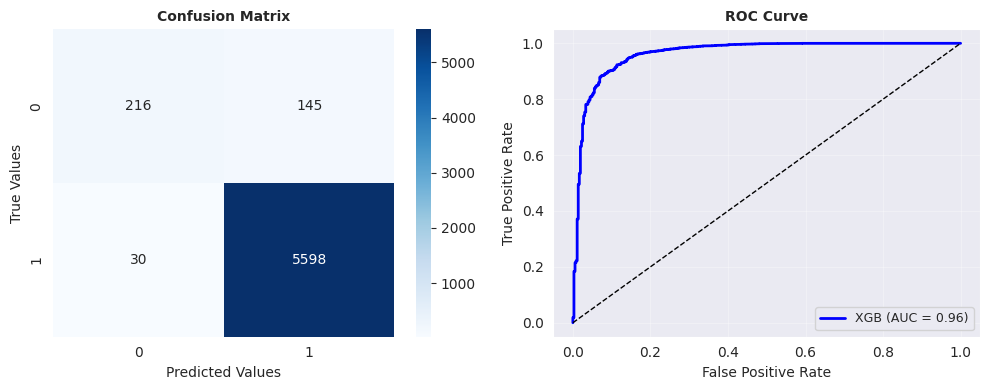

In [68]:
xgb_evaluation_metrics = evaluate_model(xgb_best_model,X_test, y_test,'XGB')

### Evaluating the metrics for all models

In [69]:
all_metrics_df

,Accuracy,Precision,Recall,F1 Score,AUC
LogisticRegression,0.92,0.99,0.92,0.96,0.97
NaiveBayes,0.89,0.99,0.90,0.94,0.95
RandomForest,0.96,0.96,1.00,0.98,0.93
XGB,0.97,0.97,0.99,0.98,0.96


### **Recommended Model: XGBoost**
#### **XGBoost's Strengths**

1.   **High Accuracy (0.97)**: This indicates that the model is very good at making correct classifications overall (both positive and negative sentiments). It has the highest accuracy among all models.
2.   **High Precision (0.97)**: This means that when XGBoost predicts a review as positive, it's correct 97% of the time.
3.   **High Recall (0.99)**: Missing some positive reviews is less harmful than including false positives.
4.   **High F1 Score (0.98)**:This indicates a strong balance between precision and recall, suggesting robust performance in identifying positive sentiments without excessive false positives or false negatives.
5.   **High AUC (0.96)**: AUC measures the model's ability to distinguish between positive and negative classes across various thresholds. A high AUC means the model is generally good at ranking positive reviews higher than negative reviews. This is valuable in a recommendation system where you might want to present a ranked list of products.



### Saving the Model

In [70]:
save_path = '/content/drive/MyDrive/Capstone/pickle_files'


In [71]:
import pickle
import os

def save_object(obj, filename):
    filename = os.path.join(save_path, filename +'.pkl')
    pickle.dump(obj, open(filename, 'wb'))

In [72]:
# Save TF-IDF Vectorizer
save_object(tfidf,'tfidf_vectorizer')

In [73]:
# Save Sentiment Model
save_object(xgb_best_model,'sentiment_xgb_model')

In [74]:
df_cleaned_data = products_review_data[['id','reviews_username', 'name', 'brand', 'categories',
               'reviews_date', 'reviews_rating', 'user_sentiment', 'cleaned_review']]



```
This keeps the essential features for:
Collaborative filtering → (reviews_username, name, reviews_rating)
Sentiment analysis → (cleaned_review, user_sentiment)
Metadata-based filtering → (brand, categories, reviews_date)
```





In [75]:
# Save Sentiment Model
save_object(df_cleaned_data, 'cleaned_data')

# 6. Build Recommendation System

In [76]:
# 1.Load review dataset

df = pd.read_csv('/content/drive/MyDrive/Capstone/sample30.csv')  # Use your cleaned dataset
df = df[['reviews_username', 'name', 'reviews_rating']].dropna()
df.head()

,reviews_username,name,reviews_rating
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
3,rebecca,K-Y Love Sensuality Pleasure Gel,1
4,walker557,K-Y Love Sensuality Pleasure Gel,1


In [77]:
# 2.Train-Test Split

train, test = train_test_split(df, test_size=0.25, random_state=42)
print(train.shape, test.shape)

(22452, 3) (7485, 3)


In [78]:
 # 3.Create User-Item Matrix

 # Pivot the train ratings into matrix format
df_pivot = train.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals 

In [79]:
# 4.Create Dummy Train & Dummy Test

# Dummy train: Mark 0 for rated items, 1 for unrated
dummy_train = train.copy()
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x >= 1 else 1)
dummy_train = dummy_train.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(1)

# Dummy test: Mark 1 for rated items, 0 for unrated
dummy_test = test.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x >= 1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

#### **5.User-Based Collaborative Filtering**


In [80]:

from sklearn.metrics.pairwise import pairwise_distances

# User similarity matrix using cosine similarity
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0

# Set negative correlations to 0
user_correlation[user_correlation < 0] = 0

# Predict ratings: Weighted sum of user similarities
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)
user_final_rating.shape

(19431, 260)

In [81]:
# 6. Top 20 Recommendations for a User (User-Based)

# Function to get top N recommendations
def get_top_n_recommendations(user_id, ratings_matrix, n=20):
    recommendations = ratings_matrix.loc[user_id].sort_values(ascending=False)[:n]
    return recommendations

user_input = input("Enter username: ")
user_final_rating_df = pd.DataFrame(user_final_rating, index=df_pivot.index, columns=df_pivot.columns)
user_recommendations_userCF = get_top_n_recommendations(user_input, user_final_rating_df, 20)
print("User-Based Recommendations:\n", user_recommendations_userCF)

Enter username: 08dallas
User-Based Recommendations:
 name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd        24.411263
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)    22.277836
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total               8.350586
Mike Dave Need Wedding Dates (dvd + Digital)                            6.504352
The Resident Evil Collection 5 Discs (blu-Ray)                          5.064475
Coty Airspun Face Powder, Translucent Extra Coverage                    4.573207
Clorox Disinfecting Bathroom Cleaner                                    3.679464
Olay Regenerist Deep Hydration Regenerating Cream                       3.535534
Chester's Cheese Flavored Puffcorn Snacks                               3.395675
Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz              2.886751
Hormel Chili, No Beans                                                  2.767059
Stargate (ws) (ultimate Edition) (director's Cut) 

In [ ]:
# Create user similarity dataframe
user_correlation_df = pd.DataFrame(user_correlation,
                                   index=df_pivot.index,  # users from train
                                   columns=df_pivot.index)

In [ ]:
# Get common users between train & test
common = test[test.reviews_username.isin(train.reviews_username)]

# Create pivot table for common users in test set
common_user_based_matrix = common.pivot_table(index='reviews_username',
                                              columns='name',
                                              values='reviews_rating')

In [ ]:
# 7. Evaluate User-Based Model

from sklearn.preprocessing import MinMaxScaler

# Only keep users present in both similarity matrix & test matrix
valid_users = user_correlation_df.index.intersection(common_user_based_matrix.index)

# Filter both rows AND columns
user_correlation_filtered = user_correlation_df.loc[valid_users, valid_users]
common_user_based_filtered = common_user_based_matrix.loc[valid_users].fillna(0)
dummy_test_filtered = dummy_test.loc[valid_users][common_user_based_filtered.columns]  # align columns

# Dot product for prediction
common_user_predicted_ratings = np.dot(user_correlation_filtered, common_user_based_filtered)
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings, dummy_test_filtered)

# Normalize and calculate RMSE
from sklearn.preprocessing import MinMaxScaler
X = common_user_predicted_ratings.copy()
X = X[X > 0]
scaler = MinMaxScaler(feature_range=(1, 5))
y = scaler.fit_transform(X)
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse_user = (np.nansum((common_user_based_filtered - y) ** 2) / total_non_nan) ** 0.5
print("User-Based CF RMSE:", rmse_user)

#### **8. Item-Based Collaborative Filtering**

In [ ]:
# Transpose for item-item similarity
df_pivot_item = train.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

# Normalize per item
mean = np.nanmean(df_pivot_item, axis=1)
df_subtracted = (df_pivot_item.T - mean).T

# Item similarity matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
item_correlation[item_correlation < 0] = 0

# Predict ratings
item_predicted_ratings = np.dot(df_pivot_item.fillna(0).T, item_correlation)
item_final_rating = np.multiply(item_predicted_ratings, dummy_train)
item_final_rating.shape

In [ ]:
# 9. Top 20 Recommendations for a User (Item-Based)

item_final_rating_df = pd.DataFrame(item_final_rating, index=df_pivot.index, columns=df_pivot.columns)
user_recommendations_itemCF = get_top_n_recommendations(user_input, item_final_rating_df, 20)
print("Item-Based Recommendations:\n", user_recommendations_itemCF)

In [ ]:
# 10. Evaluate Item-Based Model

# 1. Create common item-based test pivot
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

# 2. Build item correlation DataFrame
item_correlation_df = pd.DataFrame(item_correlation, index=df_subtracted.index, columns=df_subtracted.index)

# 3. Get common items (intersection of similarity matrix & test set)
valid_items = item_correlation_df.index.intersection(common_item_based_matrix.index)

# 4. Filter both similarity matrix and test matrix to these valid items
item_correlation_filtered = item_correlation_df.loc[valid_items, valid_items]
common_item_based_filtered = common_item_based_matrix.loc[valid_items].fillna(0)

# 5. Align dummy test mask (transpose and filter columns)
dummy_test_filtered = dummy_test.T.loc[valid_items][common_item_based_filtered.columns]

# 6. Dot product (item × item similarity with user ratings)
common_item_predicted_ratings = np.dot(item_correlation_filtered, common_item_based_filtered)

# 7. Mask out items already rated
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings, dummy_test_filtered)

# 8. Normalize & calculate RMSE
X = common_item_predicted_ratings.copy()
X = X[X > 0]
y = scaler.fit_transform(X)
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse_item = (np.nansum((common_item_based_filtered - y) ** 2) / total_non_nan) ** 0.5
print("Item-Based CF RMSE:", rmse_item)

In [88]:
# 11. Select Best Model

if rmse_item < rmse_user:
    print("Item-Based Collaborative Filtering is better suited as it has lower RMSE -",{rmse_item})
    final_recommendations = user_recommendations_itemCF
else:
    print("User-Based Collaborative Filtering is better suited as it has lower RMSE -",{rmse_user})
    final_recommendations = user_recommendations_userCF


User-Based Collaborative Filtering is better suited as it has lower RMSE - {np.float64(2.0848418524674477)}


In [89]:
# saving the correlation matrix of user based recommender

save_object(user_final_rating, "user_final_rating")

### **Top Product Recommendations - Recommendation of 20 products**

In [90]:
print("\nFinal Top 20 Recommendations for user:", user_input)
print(final_recommendations)


Final Top 20 Recommendations for user: 08dallas
name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd        24.411263
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)    22.277836
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total               8.350586
Mike Dave Need Wedding Dates (dvd + Digital)                            6.504352
The Resident Evil Collection 5 Discs (blu-Ray)                          5.064475
Coty Airspun Face Powder, Translucent Extra Coverage                    4.573207
Clorox Disinfecting Bathroom Cleaner                                    3.679464
Olay Regenerist Deep Hydration Regenerating Cream                       3.535534
Chester's Cheese Flavored Puffcorn Snacks                               3.395675
Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz              2.886751
Hormel Chili, No Beans                                                  2.767059
Stargate (ws) (ultimate Edition) (director's Cut) (dvdv

In [91]:
products_review_data.info()



<class 'pandas.core.frame.DataFrame'>
Index: 29943 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   29943 non-null  object
 1   brand                29943 non-null  object
 2   categories           29943 non-null  object
 3   manufacturer         29802 non-null  object
 4   name                 29943 non-null  object
 5   reviews_date         29897 non-null  object
 6   reviews_didPurchase  15894 non-null  object
 7   reviews_doRecommend  27375 non-null  object
 8   reviews_rating       29943 non-null  int64 
 9   reviews_text         29943 non-null  object
 10  reviews_title        29753 non-null  object
 11  reviews_username     29880 non-null  object
 12  user_sentiment       29943 non-null  int64 
 13  full_review          29943 non-null  object
 14  cleaned_review       29943 non-null  object
dtypes: int64(2), object(13)
memory usage: 3.7+ MB


In [111]:
def get_sentiment_filtered_recommendations(user_id,n_recommendations=20,n_final=5):
      # Step 1: Get top N recommendations using CF
    if user_id not in user_final_rating_df.index:
        print(f"User '{user_id}' doesnt exist")
        return pd.Series([])

    user_recommendations = user_final_rating_df.loc[user_id].sort_values(ascending=False)[:n_recommendations]
    recommended_products = user_recommendations.index.tolist()

    # Step 2: Filter reviews for these products
    top_reviews = df_cleaned_data[df_cleaned_data['name'].isin(recommended_products)]
    if top_reviews.empty:
        print(f"No reviews found for the recommended products for user '{user_id}'.")
        return pd.Series([])

    # Step 3: Preprocess & vectorize reviews
    top_reviews['processed_text'] = top_reviews['cleaned_review'].fillna('').astype(str)
    X_reviews = tfidf.transform(top_reviews['processed_text'])

    # Step 4: Predict sentiment probabilities
    top_reviews['sentiment_score'] = xgb_best_model.predict_proba(X_reviews)[:, 1]  # Probability of positive

    # Step 5: Aggregate sentiment by product
    product_sentiment_scores = top_reviews.groupby('name')['sentiment_score'].mean().sort_values(ascending=False)

    # Step 6: Pick top-N final recommendations
    top_final_recommendations = product_sentiment_scores.head(n_final)

    return top_final_recommendations

In [112]:
#get the top 5
get_sentiment_filtered_recommendations("08dallas")

,sentiment_score
name,
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,0.996012
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),0.992187
Clorox Disinfecting Bathroom Cleaner,0.989742
Red (special Edition) (dvdvideo),0.989097
The Resident Evil Collection 5 Discs (blu-Ray),0.983627


In [100]:
#testing the above fuction on the user that doesn't exists or a new user

get_sentiment_filtered_recommendations("test123")

User 'test123' doesnt exist


,0


In [ ]:
# Heroku URL - https://sentiment-recommender-ba637b2d7e39.herokuapp.com/predict